# Importing Packages

### 1) import tensoflow and other related packages

In [12]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from pandas.api.types import CategoricalDtype 
from sklearn import metrics
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix
import keras_tuner as kt

#%load_ext tensorboard => I am running tensorboard from Terminal


### 2) import additional packages

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math 
import shutil
import os
import time
import json

plt.rcParams['figure.figsize'] = [9, 6]
sns.set_style("darkgrid")
base_log_dir = "./logs/"

if not os.path.exists(base_log_dir):
    os.makedirs(base_log_dir)


### 3) simple utils to handel some implementation

In [14]:
def CalculateMetricsAndPlot(true_label, predicted_label,color="Blues",text=""):
    CM = confusion_matrix(true_label, predicted_label)
    acc = round(accuracy_score(true_label,predicted_label)*100,2)
    precision = round(precision_score(true_label,predicted_label, average='macro'),2)
    if text == "":
        sns.heatmap(CM ,annot=True, cmap=color, fmt='g').set_title("Confusion Matrix for Test Data | Accuracy={0}% | Precision={1}".format(acc,precision))
    else :
        sns.heatmap(CM ,annot=True, cmap=color, fmt='g').set_title("Confusion Matrix for Test Data | Accuracy={0}% | Precision={1} | {2}".format(acc,precision,text))
    
    plt.show()

# Loading Dataset & Split

In [15]:
with open('X_test.npy', 'rb') as f:
    X_test = np.load(f)
with open('X_valid.npy', 'rb') as f:
    X_valid = np.load(f)
with open('X_train.npy', 'rb') as f:
    X_train = np.load(f)
    
with open('Y_test.npy', 'rb') as f:
    Y_test = np.load(f)
with open('Y_valid.npy', 'rb') as f:
    Y_valid = np.load(f)
with open('Y_train.npy', 'rb') as f:
    Y_train = np.load(f)
      
Total_count = X_train.shape[0]+X_valid.shape[0]+X_test.shape[0]
Y_test,Y_valid,Y_train = Y_test-1,Y_valid-1,Y_train-1

print("percentage of Train: {0}%".format(round(X_train.shape[0]/Total_count*100,2)))
print("percentage of Validation: {0}%".format(round(X_valid.shape[0]/Total_count*100,2)))
print("percentage of Test: {0}%".format(round(X_test.shape[0]/Total_count*100,2)))


percentage of Train: 60.68%
percentage of Validation: 10.71%
percentage of Test: 28.61%


# Custom MLP Builder 

In [16]:
class SequentialANN :
    def __init__(self,_shape_input:tuple,label_count,_neurons : list,id=None):
        self.model = keras.models.Sequential()
        keras.backend.clear_session()
        self.model.add(keras.layers.Input(shape=_shape_input))
        self.model.add(keras.layers.Flatten())
        
        for n in range(len(_neurons)) :
            self.model.add(keras.layers.Dense(_neurons[n],activation="sigmoid"))

        self.model.add(keras.layers.Dense(label_count, activation='softmax'))
        
        self.id = id 
        self.log_dir = base_log_dir+str(id)+"/"
        
            
    def compile(self,_optimizer='adam',_loss='sparse_categorical_crossentropy', _metrics=["accuracy"]):
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)
        else:
            shutil.rmtree(self.log_dir, ignore_errors=True)
            os.makedirs(self.log_dir)
        self.model.compile(optimizer=_optimizer, loss=_loss,metrics=_metrics)
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=self.log_dir, histogram_freq=1)
        self.tensorboard_callback = tensorboard_callback
        
        self.optimizer = _optimizer
        self.loss = _loss 
        self.metrics = _metrics
        
    def fit(self,**argu):
        self.model.fit(**argu)
        
        _text_log_dir = self.log_dir+"Parameter Logs"
        
        if not os.path.exists(_text_log_dir):
            os.makedirs(_text_log_dir)
        else:
            shutil.rmtree(_text_log_dir, ignore_errors=True)
            os.makedirs(_text_log_dir)
            
        file_writer = tf.summary.create_file_writer(_text_log_dir)
        self.optimizer = "adam"
        argu["optimizer"] = self.optimizer
        argu["loss"] = self.loss
        argu["metrics"] = self.metrics
        
        
        argu["Test loss"],argu["Test accuracy"] = self.model.evaluate(X_test,Y_test)        
        
        del argu["x"]
        del argu["y"]
        del argu ["validation_data"]
        del argu["callbacks"]
        
        index = 0
        for key in argu:
            with file_writer.as_default():                            
                tf.summary.text("Parameter report: "+str(key), str(key) + " : " +str(argu[key]) , step=index)
                index+=1    
                
        
        with open(self.log_dir + "json_report.json", 'w') as outfile:
            json.dump(argu, outfile)
        self.save()
        self.plot()
        
            
    def save(self):
        self.model.save(self.log_dir+"model.h5")
        
    def plot(self):
        keras.utils.plot_model(self.model,to_file=self.log_dir+"graph.png",show_shapes=True,expand_nested=True,show_layer_activations=True,show_dtype=True,show_layer_names=False)
        
        

# Training MLPs on dataset

### Finding optimal parameters for # layers & # units(Keras Tuner)

In [17]:
def ModelBuilder(hyperparameter):
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    for i in range(hyperparameter.Int("num_layers", 1, 6)):
        model.add(
            keras.layers.Dense(
                units=hyperparameter.Int(f"units_{i}", min_value=64, max_value=1024, step=64),
                activation= "sigmoid",
            )
        )

    model.add(keras.layers.Dense(6, activation="softmax"))    
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

tuner = kt.RandomSearch(ModelBuilder,objective='val_accuracy',max_trials=30)
tuner.search(X_train, Y_train, epochs=50, validation_data=(X_valid, Y_valid))
tuner.results_summary()

Trial 30 Complete [00h 01m 07s]
val_accuracy: 0.8766999244689941

Best val_accuracy So Far: 0.8966454863548279
Total elapsed time: 01h 18m 26s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 2
units_0: 192
units_1: 576
units_2: 128
units_3: 1024
units_4: 256
units_5: 640
Score: 0.8966454863548279
Trial summary
Hyperparameters:
num_layers: 2
units_0: 704
units_1: 384
units_2: 512
units_3: 320
units_4: 960
units_5: 832
Score: 0.893925666809082
Trial summary
Hyperparameters:
num_layers: 2
units_0: 576
units_1: 384
units_2: 512
units_3: 384
units_4: 640
units_5: 384
Score: 0.893925666809082
Trial summary
Hyperparameters:
num_layers: 3
units_0: 448
units_1: 128
units_2: 192
units_3: 576
units_4: 192
units_5: 512
Score: 0.8921124339103699
Trial summary
Hyperparameters:
num_layers: 2
units_0: 448
units_1: 512
units_2: 256
units_3: 320
units_4: 6

### Finding optimal parameter for LR (manual)

In [19]:
LRs = [0.5,0.1,0.01,0.001,0.0001]

for lr in LRs:
    optimizer = tf.keras.optimizers.Adam(lr)
    time.sleep(5)
    optimizer.learning_rate.assign(lr)
    print(optimizer.learning_rate)
    model = SequentialANN((X_train.shape[1],X_train.shape[1]),6,[1024,128],"Extracted featrue - LR {0}".format(lr))
    model.compile(optimizer)
    model.fit(x=X_train, 
                    y=Y_train, 
                    batch_size=48,
                    epochs=100, 
                    verbose=0,
                    validation_data=(X_valid, Y_valid),callbacks=[model.tensorboard_callback])
                


<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.5>
93/93 [==============================] - 0s 3ms/step - loss: 6.8472 - accuracy: 0.1822
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.1>
93/93 [==============================] - 0s 4ms/step - loss: 2.0300 - accuracy: 0.1805
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.01>
93/93 [==============================] - 0s 3ms/step - loss: 1.8171 - accuracy: 0.1822
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>
93/93 [==============================] - 0s 4ms/step - loss: 0.3212 - accuracy: 0.8585
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
93/93 [==============================] - 0s 3ms/step - loss: 0.5033 - accuracy: 0.7988


### Training optimal MLP 

In [20]:
model = SequentialANN((X_train.shape[1],X_train.shape[2]),6,[1024,128],"Main-Extracted-Features")
model.compile()
model.fit(x=X_train, 
                y=Y_train, 
                epochs=100, 
                verbose=1,
                validation_data=(X_valid, Y_valid),callbacks=[model.tensorboard_callback])
            


Epoch 1/100
196/196 [==============================] - 3s 10ms/step - loss: 1.6010 - accuracy: 0.2957 - val_loss: 1.1875 - val_accuracy: 0.3744
Epoch 2/100
196/196 [==============================] - 2s 10ms/step - loss: 1.0716 - accuracy: 0.4770 - val_loss: 0.9496 - val_accuracy: 0.5014
Epoch 3/100
196/196 [==============================] - 2s 10ms/step - loss: 0.8883 - accuracy: 0.5482 - val_loss: 0.8031 - val_accuracy: 0.6038
Epoch 4/100
196/196 [==============================] - 2s 9ms/step - loss: 0.7803 - accuracy: 0.6089 - val_loss: 0.7683 - val_accuracy: 0.5984
Epoch 5/100
196/196 [==============================] - 2s 10ms/step - loss: 0.7131 - accuracy: 0.6657 - val_loss: 0.6905 - val_accuracy: 0.6646
Epoch 6/100
196/196 [==============================] - 2s 9ms/step - loss: 0.6633 - accuracy: 0.6918 - val_loss: 0.6313 - val_accuracy: 0.7452
Epoch 7/100
196/196 [==============================] - 2s 10ms/step - loss: 0.6106 - accuracy: 0.7248 - val_loss: 0.5945 - val_accuracy: 0

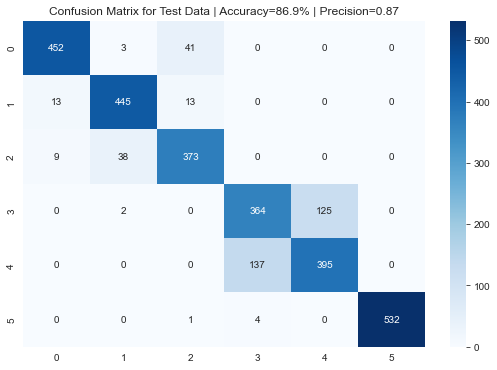

In [21]:
CalculateMetricsAndPlot(Y_test,np.argmax(model.model.predict(X_test), axis=-1))